In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [8]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain import hub
from chromadb.utils import embedding_functions

embedding_function = OpenAIEmbeddings()

docs = [
    Document(
        page_content="Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.",
        metadata={"source": "owner.txt"},
    ),
    Document(
        page_content="Bella Vista offers a range of dishes with prices that cater to various budgets. Appetizers start at $8, main courses range from $15 to $35, and desserts are priced between $6 and $12.",
        metadata={"source": "dishes.txt"},
    ),
    Document(
        page_content="Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.",
        metadata={"source": "restaurant_info.txt"},
    ),
    Document(
        page_content="Bella Vista offers a variety of menus including a lunch menu, dinner menu, and a special weekend brunch menu. The lunch menu features light Italian fare, the dinner menu offers a more extensive selection of traditional and contemporary dishes, and the brunch menu includes both classic breakfast items and Italian specialties.",
        metadata={"source": "restaurant_info.txt"},
    ),
]

db = Chroma.from_documents(docs, embedding_function)
# retriever = db.as_retriever()
retriever = db.as_retriever(search_kwargs={"k": 2})

In [9]:
prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model="gpt-4o-mini")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = prompt | llm

/home/safeer/Documents/devops/agents/LangGraph-Agents/.venv-agent/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [11]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain.schema import Document


class AgentState(TypedDict):
    messages: list[BaseMessage]
    documents: list[Document]
    on_topic: str

In [12]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


class GradeQuestion(BaseModel):
    """Boolean value to check whether a question is releated to the restaurant Bella Vista"""

    score: str = Field(
        description="Question is about restaurant? If yes -> 'Yes' if not -> 'No'"
    )


def question_classifier(state: AgentState):
    question = state["messages"][-1].content

    system = """You are a classifier that determines whether a user's question is about one of the following topics:

    1. Information about the owner of Bella Vista, which is Antonio Rossi.
    2. Prices of dishes at Bella Vista (restaurant).
    3. Opening hours of Bella Vista (restaurant).

    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'. Remember, ONLY YES or NO, nothing else in the reponse!
    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: {question}"),
        ]
    )

    llm = ChatOpenAI(model="gpt-4o-mini")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    print("RESULT", result)
    state["on_topic"] = result.score
    return state

In [13]:
def on_topic_router(state):
    on_topic = state["on_topic"]
    if on_topic.lower() == "yes":
        return "on_topic"
    return "off_topic"


def retrieve(state):
    question = state["messages"][-1].content
    documents = retriever.invoke(question)
    state["documents"] = documents
    return state


def generate_answer(state):
    question = state["messages"][-1].content
    documents = state["documents"]
    generation = rag_chain.invoke({"context": documents, "question": question})
    state["messages"].append(generation)
    return state


def off_topic_response(state: AgentState):
    state["messages"].append(AIMessage(content="I cant respond to that!"))
    return state

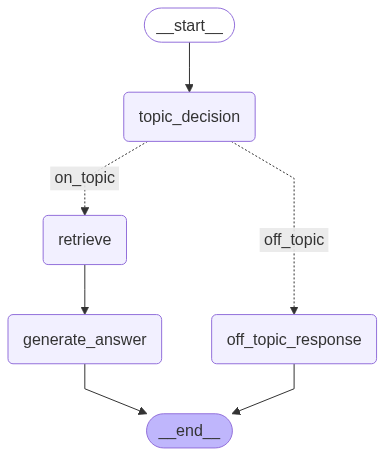

In [15]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate_answer", generate_answer)

workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,
    {
        "on_topic": "retrieve",
        "off_topic": "off_topic_response",
    },
)

workflow.add_edge("retrieve", "generate_answer")
workflow.add_edge("generate_answer", END)
workflow.add_edge("off_topic_response", END)

workflow.set_entry_point("topic_decision")
graph = workflow.compile()
graph

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
graph.invoke(
    input={
        "messages": [HumanMessage(content="When does the bella vista restaurant open?")]
    }
)

In [ ]:
graph.invoke(
    input={"messages": [HumanMessage(content="What is articial intelligence?")]}
)

### Retrieval with Tools

In [ ]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_tool",
    "Information related to Pricing, Opening hours of the owner of the restaurant Bella Vista",
)


@tool
def off_topic():
    """Catch all Questions NOT related to Pricing, Opening hours of the owner of the restaurant Bella Vista"""
    return "Forbidden - do not respond to the user"


tools = [retriever_tool, off_topic]

In [ ]:
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI


def agent(state):
    messages = state["messages"]
    model = ChatOpenAI()
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}


def should_continue(state) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [ ]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)

tool_node = ToolNode(tools)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile()

In [ ]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
graph.invoke(
    input={"messages": [HumanMessage(content="How will the weather be tommorrow?")]}
)

In [ ]:
graph.invoke(
    input={
        "messages": [HumanMessage(content="When does the bella vista restaurant open?")]
    }
)